# Create source data

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None

import sys
sys.path.append('../../common/')
import settings
settings.set_arial_as_font()

import matplotlib.pyplot as plt
import numpy as np
import math
from matplotlib.lines import Line2D

%matplotlib inline

In [2]:
preclinical_root = '/Users/brendan/Github/moalmanac-paper/analyses/preclinical'

handle = f'{preclinical_root}/formatted/sanger.gdsc.txt'
gdsc =  pd.read_csv(handle, sep='\t')

handle = f'{preclinical_root}/formatted/ccle.variants.txt'
variants = pd.read_csv(handle, sep='\t')

handle = f'{preclinical_root}/formatted/ccle.copy-numbers.txt'
cna = pd.read_csv(handle, sep='\t')

handle = f'{preclinical_root}/formatted/sanger.fusions.txt'
fusion = pd.read_csv(handle, sep='\t')

handle = f'{preclinical_root}/formatted/cell-lines.summary.txt'
summary = pd.read_csv(handle, sep='\t')

In [3]:
df = gdsc[gdsc['therapy_name'].eq('Pictilisib')]
df.reset_index(drop=True, inplace=True)

sanger_to_ccle = (
    summary
    .loc[:, ['sanger', 'ccle_name']]
    .set_index('sanger')
    .to_dict()['ccle_name']
)

sanger_to_broad = (
    summary
    .loc[:, ['sanger', 'broad']]
    .set_index('sanger')
    .to_dict()['broad']
)

df.loc[df.index, 'broad'] = df.loc[df.index, 'model_id'].map(sanger_to_broad)
df.loc[df.index, 'ccle'] = df.loc[df.index, 'model_id'].map(sanger_to_ccle)

df.head()

,DATASET,model_id,therapy_name,ln_ic50,AUC,z_score,broad,ccle
0,GDSC2,SIDM00412,Pictilisib,-3.286888,0.291951,-3.766375,ACH-001709,WSUNHL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE
1,GDSC2,SIDM00407,Pictilisib,-3.169828,0.301248,-3.672634,ACH-000611,SUDHL6_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE
2,GDSC2,SIDM01148,Pictilisib,-2.089101,0.440165,-2.807196,ACH-000050,NCIH929_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE
3,GDSC2,SIDM01057,Pictilisib,-1.772624,0.480963,-2.553763,ACH-000081,GDM1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE
4,GDSC2,SIDM00406,Pictilisib,-1.758086,0.480973,-2.542122,ACH-000660,SUDHL5_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE


In [4]:
pik3ca_mut_variants = (variants
                       .loc[variants['feature'].eq('PIK3CA'), 'model_id']
                       .reset_index(drop=True)
                       .drop_duplicates()
                       .tolist()
                      )

pik3ca_mut_variants_missense = (variants
                                .loc[variants['feature'].eq('PIK3CA') & variants['alteration_type'].eq('Missense'), 'model_id']
                                .reset_index(drop=True)
                                .drop_duplicates()
                                .tolist()
                               )

pik3ca_mut_variants_H1047R = (variants
                                .loc[variants['feature'].eq('PIK3CA') & variants['alteration'].eq('p.H1047R'), 'model_id']
                                .reset_index(drop=True)
                                .drop_duplicates()
                                .tolist()
                               )

pik3ca_mut_cna = (cna
                 .loc[cna['feature'].eq('PIK3CA'), 'model_id']
                 .reset_index(drop=True)
                 .drop_duplicates()
                 .tolist()
                 )

pik3ca_mut_fusions = (fusion
                      .loc[(fusion['feature'].eq('PIK3CA') | fusion['partner'].eq('PIK3CA')), 'model_id']
                      .reset_index(drop=True)
                      .drop_duplicates()
                      .tolist()
)


idx = df['ccle'].isin(pik3ca_mut_variants) | df['ccle'].isin(pik3ca_mut_cna) | df['model_id'].isin(pik3ca_mut_fusions)

df.loc[idx, 'PIK3CA'] = 1
df.loc[df['ccle'].isin(pik3ca_mut_variants), 'PIK3CA somatic variant'] = 1
df.loc[df['ccle'].isin(pik3ca_mut_variants_missense), 'PIK3CA missense'] = 1
df.loc[df['ccle'].isin(pik3ca_mut_variants_H1047R), 'PIK3CA p.H1047R'] = 1

df.fillna(0, inplace=True)

In [5]:
df['ic50'] = np.exp(df['ln_ic50'])
drug = 'Pictilisib'

for column in df.columns[df.columns.str.contains('PIK3CA')]:
    print(column)
    print(df[column].value_counts())
    print('')
    
    mut = df[df[column].eq(1)]['ic50']
    wt = df[df[column].eq(0)]['ic50']
    print(f'min: {mut.min()}, {wt.min()}')
    print(f'max: {mut.max()}, {wt.max()}')
    print(f'median: {mut.median()}, {wt.median()}')
    print(f'q1: {mut.quantile(q=0.25)}, {wt.quantile(q=0.25)}')
    print(f'q3: {mut.quantile(q=0.75)}, {wt.quantile(q=0.75)}')
    
    print('')

PIK3CA
0.0    604
1.0    162
Name: PIK3CA, dtype: int64

min: 0.17564576693348644, 0.037369963956082296
max: 93.91940303888369, 1616.647759434702
median: 3.216359388517004, 4.099483675716648
q1: 1.7031761636431648, 1.9350761115655766
q3: 6.715411793069032, 9.338621458822805

PIK3CA somatic variant
0.0    663
1.0    103
Name: PIK3CA somatic variant, dtype: int64

min: 0.17564576693348644, 0.037369963956082296
max: 50.011751109262065, 1616.647759434702
median: 2.897675894507123, 4.103716391107722
q1: 1.4199403467358784, 1.9531282339533296
q3: 5.138397053385854, 9.537577286228826

PIK3CA missense
0.0    668
1.0     98
Name: PIK3CA missense, dtype: int64

min: 0.17564576693348644, 0.037369963956082296
max: 50.011751109262065, 1616.647759434702
median: 2.9071560969347106, 4.099483675716648
q1: 1.4587741389531697, 1.9433277797577135
q3: 5.105169981340183, 9.608450868946115

PIK3CA p.H1047R
0.0    745
1.0     21
Name: PIK3CA p.H1047R, dtype: int64

min: 0.542282606079732, 0.037369963956082296

In [6]:
df.to_excel('source-data-extended-data-fig-3.xlsx', sheet_name='SF6', index=False)

# Create figure

In [7]:
class Illustrator(object):
    tableau10 = {
        'blue': (78, 121, 167), 'orange': (242, 142, 43), 'red': (225, 87, 89),
        'cyan': (118, 183, 178), 'green': (89, 161, 79), 'yellow': (237, 201, 72),
        'purple': (176, 122, 161), 'pink': (225, 157, 167), 'brown': (156, 117, 95),
        'grey': (186, 176, 172)}

    for color in tableau10.keys():
        r, g, b = tableau10[color]
        tableau10[color] = (r / 255., g / 255., b / 255.)

    #@staticmethod
    #def save_fig(figure, patient_id, suffix):
    #    outname = '.'.join([patient_id, suffix])
    #    figure.savefig(outname, bbox_inches='tight')

def draw_boxplot(data, offset, width, axis, edge_color, alpha):
            for i in np.arange(1, len(data) + 1):
                x = np.random.normal(i, 0.04, size=len(data[i - 1]))
                plt.plot(x + offset, data[i - 1], color=edge_color, marker='.', markersize=2, alpha=alpha, linestyle='None')

            pos = np.arange(1, len(data) + 1) + offset
            bp = axis.boxplot(data, positions=pos, widths=width, showfliers=False)
            for element in ['boxes', 'whiskers', 'caps']:
                plt.setp(bp[element], color=Illustrator.tableau10['grey'], linewidth=1)
            for element in ['medians']:
                plt.setp(bp[element], color=Illustrator.tableau10['orange'], linewidth=1)
            return bp

def create_legend(color1, color2, label1, label2, font_size, location, frame_on):
            item1 = Line2D([0], [0], color='w', markerfacecolor=color1, label=label1, marker='o', markersize=5)
            item2 = Line2D([0], [0], color='w', markerfacecolor=color2, label=label2, marker='o', markersize=5)
            plt.legend(handles=[item1, item2], fontsize=font_size, loc=location, frameon=frame_on, ncol=2)

def create_title(string):
            return 'Sensitivity of wild-type and mutant cell lines to {} (GDSC)'.format(string)
    
def create_y_range(values):
        minimum = min(values)
        maximum = max(values)

        yaxis_minimum_log10 = math.floor(math.log10(minimum)) - 0
        yaxis_maximum_log10 = math.ceil(math.log10(maximum)) + 1

        yticks = []
        for item in range(yaxis_minimum_log10, yaxis_maximum_log10):
            yticks.append(10**item)
        return yticks

PIK3CA
PIK3CA somatic variant
PIK3CA missense
PIK3CA p.H1047R


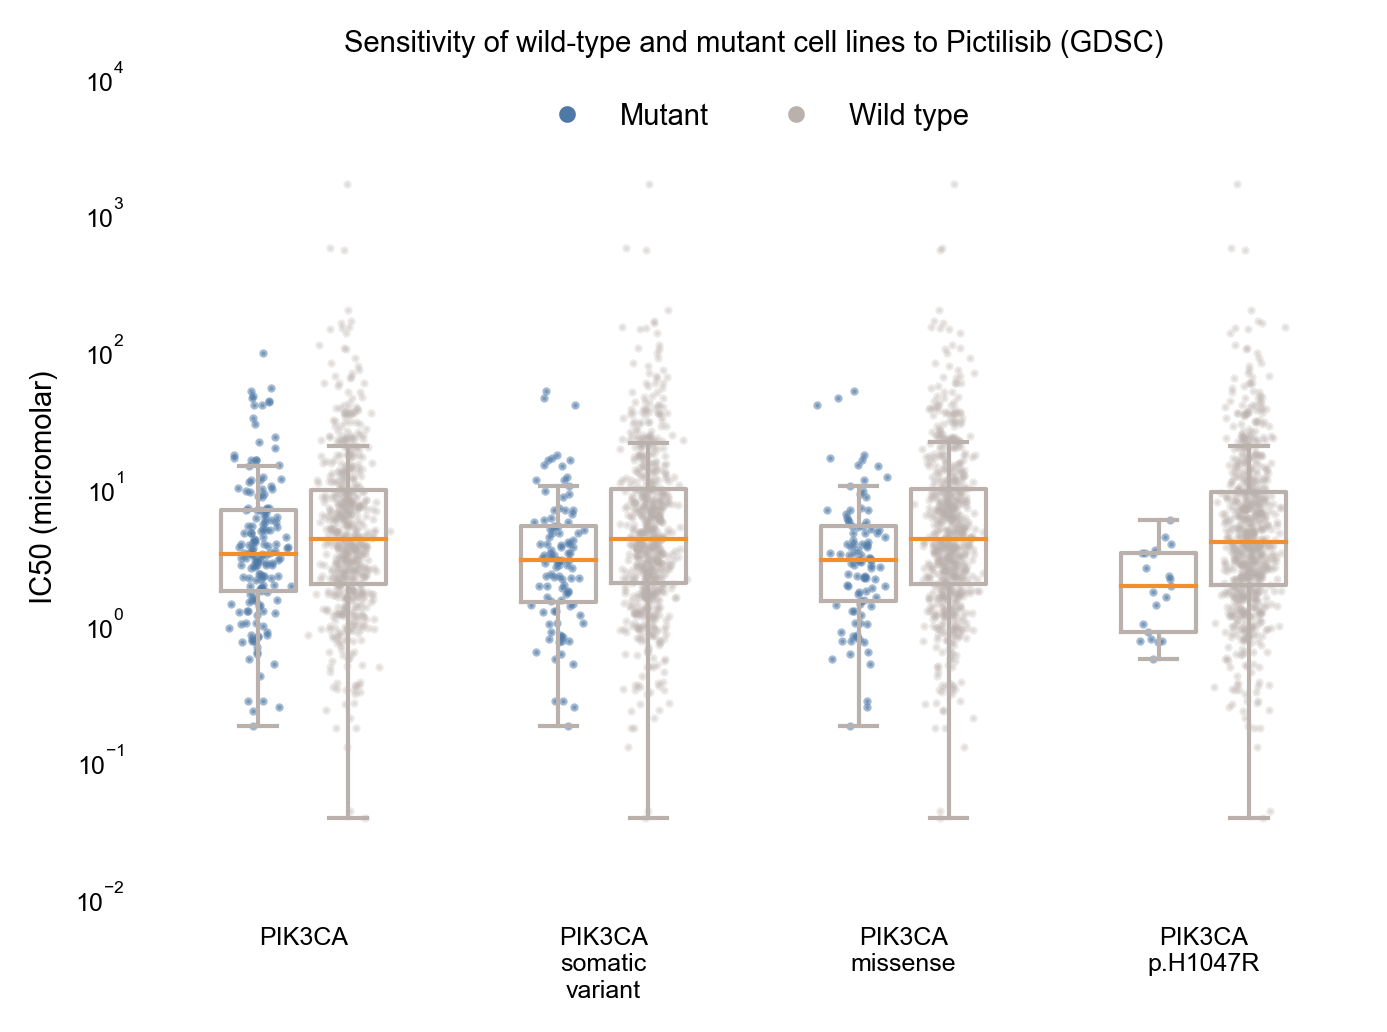

In [8]:
wt_values_list = []
mut_values_list = []
n_wt = []
n_mut = []

features = df.columns[-5:-1]
for feature in features:
    print(feature)
    wt_values = df.loc[df[feature].eq(0), 'ic50'].tolist()
    mut_values = df.loc[df[feature].eq(1), 'ic50'].tolist()
    wt_values_list.append(wt_values)
    mut_values_list.append(mut_values)
    n_wt.append(len(wt_values))
    n_mut.append(len(mut_values))

cm = 1/2.54
fig = plt.figure(figsize=(12*cm, 9*cm), dpi=300)
ax = plt.subplot()
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
plt.tick_params(axis="both", which="both", bottom=False, top=False,
                labelbottom=True, left=False, right=False, labelleft=True)

bp_mut = draw_boxplot(mut_values_list, -0.15, 0.25, ax, Illustrator.tableau10['blue'], 0.50)
bp_wt = draw_boxplot(wt_values_list, +0.15, 0.25, ax, Illustrator.tableau10['grey'], 0.25)

#outliers = [flier.get_ydata() for flier in bp["fliers"]]
mut_boxes = [box.get_ydata() for box in bp_mut["boxes"]]
mut_medians = [median.get_ydata() for median in bp_mut["medians"]]
mut_whiskers = [whiskers.get_ydata() for whiskers in bp_mut["whiskers"]]
wt_whiskers = [whiskers.get_ydata() for whiskers in bp_wt["whiskers"]]
        
plt.xlim([0.5, 4 + 0.5])
plt.yscale('log')
ax.set_yticks(create_y_range(wt_values_list[0] + mut_values_list[0]))
ax.set_xticks(np.arange(1, len(features) + 1))
ax.set_xticklabels([s.replace(' ', '\n') for s in features])

plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.ylabel('IC50 (micromolar)', fontsize=7)
plt.title(create_title(drug),  fontsize=7)
plt.tight_layout()

create_legend(Illustrator.tableau10['blue'], Illustrator.tableau10['grey'], 'Mutant', 'Wild type', 7, 9, False)

filename = 'extended-data-fig-3'
for suffix in ['eps', 'pdf', 'png', 'svg']:
    outname = f'{filename}.{suffix}'
    plt.savefig(outname, format=suffix, bbox_inches='tight', dpi=300)

plt.show()